## Practice: A Visual Notebook to Using BERT for the First Time

*Credits: first part of this notebook belongs to Jay Alammar and his [great blog post](http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/) (while it has minor changes). His blog is a great way to dive into the DL and NLP concepts.*

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-sentence-classification.png" />

In this notebook, we will use pre-trained deep learning model to process some text. We will then use the output of that model to classify the text. The text is a list of sentences from film reviews. And we will calssify each sentence as either speaking "positively" about its subject of "negatively".

### Models: Sentence Sentiment Classification
Our goal is to create a model that takes a sentence (just like the ones in our dataset) and produces either 1 (indicating the sentence carries a positive sentiment) or a 0 (indicating the sentence carries a negative sentiment). We can think of it as looking like this:

<img src="https://jalammar.github.io/images/distilBERT/sentiment-classifier-1.png" />

Under the hood, the model is actually made up of two model.

* DistilBERT processes the sentence and passes along some information it extracted from it on to the next model. DistilBERT is a smaller version of BERT developed and open sourced by the team at HuggingFace. It’s a lighter and faster version of BERT that roughly matches its performance.
* The next model, a basic Logistic Regression model from scikit learn will take in the result of DistilBERT’s processing, and classify the sentence as either positive or negative (1 or 0, respectively).

The data we pass between the two models is a vector of size 768. We can think of this of vector as an embedding for the sentence that we can use for classification.


<img src="https://jalammar.github.io/images/distilBERT/distilbert-bert-sentiment-classifier.png" />

## Dataset
The dataset we will use in this example is [SST2](https://nlp.stanford.edu/sentiment/index.html), which contains sentences from movie reviews, each labeled as either positive (has the value 1) or negative (has the value 0):


<table class="features-table">
  <tr>
    <th class="mdc-text-light-green-600">
    sentence
    </th>
    <th class="mdc-text-purple-600">
    label
    </th>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      apparently reassembled from the cutting room floor of any given daytime soap
    </td>
    <td class="mdc-bg-purple-50">
      0
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      they presume their audience won't sit still for a sociology lesson
    </td>
    <td class="mdc-bg-purple-50">
      0
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      this is a visually stunning rumination on love , memory , history and the war between art and commerce
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      jonathan parker 's bartleby should have been the be all end all of the modern office anomie films
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
</table>

## Installing the transformers library
Let's start by installing the huggingface transformers library so we can load our deep learning NLP model.

In [0]:
# !pip install transformers

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

## Part 1. Using BERT for text classification.

### Importing the dataset
We'll use pandas to read the dataset and load it into a dataframe.

In [0]:
df = pd.read_csv(
    'https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv',
    delimiter='\t',
    header=None
)

For performance reasons, we'll only use 2,000 sentences from the dataset

In [0]:
batch_1 = df[:2000]

We can ask pandas how many sentences are labeled as "positive" (value 1) and how many are labeled "negative" (having the value 0)

In [7]:
batch_1[1].value_counts()

1    1041
0     959
Name: 1, dtype: int64

## Loading the Pre-trained BERT model
Let's now load a pre-trained BERT model. 

In [8]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, 
                          ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [13]:
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

Right now, the variable `model` holds a pretrained distilBERT model -- a version of BERT that is smaller, but much faster and requiring a lot less memory.

### Step #1: Preparing the Dataset
Before we can hand our sentences to BERT, we need to so some minimal processing to put them in the format it requires.

### Tokenization
Our first step is to tokenize the sentences -- break them up into word and subwords in the format BERT is comfortable with.

In [0]:
tokenized = batch_1[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-tokenization-2-token-ids.png" />

### Padding
After tokenization, `tokenized` is a list of sentences -- each sentences is represented as a list of tokens. We want BERT to process our examples all at once (as one batch). It's just faster that way. For that reason, we need to pad all lists to the same size, so we can represent the input as one 2-d array, rather than a list of lists (of different lengths).

In [0]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

Our dataset is now in the `padded` variable, we can view its dimensions below:

In [15]:
np.array(padded).shape

(2000, 59)

### Masking
If we directly send `padded` to BERT, that would slightly confuse it. We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input. That's what attention_mask is:

In [17]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2000, 59)

### Step #1: And Now, Deep Learning!
Now that we have our model and inputs ready, let's run our model!

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-tutorial-sentence-embedding.png" />

The `model()` function runs our sentences through BERT. The results of the processing will be returned into `last_hidden_states`.

In [0]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

Let's slice only the part of the output that we need. That is the output corresponding the first token of each sentence. The way BERT does sentence classification, is that it adds a token called `[CLS]` (for classification) at the beginning of every sentence. The output corresponding to that token can be thought of as an embedding for the entire sentence.

<img src="https://jalammar.github.io/images/distilBERT/bert-output-tensor-selection.png" />

We'll save those in the `features` variable, as they'll serve as the features to our logitics regression model.

In [19]:
input_ids.shape

torch.Size([2000, 59])

In [20]:
last_hidden_states[0].shape

torch.Size([2000, 59, 768])

In [0]:
features = last_hidden_states[0][:,0,:].numpy()

In [22]:
features.shape

(2000, 768)

The labels indicating which sentence is positive and negative now go into the `labels` variable

In [0]:
labels = batch_1[1]

In [24]:
labels.shape

(2000,)

### Step #3: Train/Test Split
Let's now split our datset into a training set and testing set (even though we're using 2,000 sentences from the SST2 training set).

In [0]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-train-test-split-sentence-embedding.png" />

### [Extra] Grid Search for Parameters
We can dive into Logistic regression directly with the Scikit Learn default parameters, but sometimes it's worth searching for the best value of the C parameter, which determines regularization strength.

In [29]:
parameters = {'C': np.linspace(0.0001, 100, 100)}
grid_search = GridSearchCV(LogisticRegression(), parameters)
grid_search.fit(train_features, train_labels)

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)

best parameters:  {'C': 1.0102}
best scrores:  0.8326666666666668


We now train the LogisticRegression model. If you've chosen to do the gridsearch, you can plug the value of C into the model declaration (e.g. `LogisticRegression(C=5.2)`).

In [0]:
lr_clf = grid_search.best_estimator_
# LogisticRegression()
# lr_clf.fit(train_features, train_labels)

<img src="https://jalammar.github.io/images/distilBERT/bert-training-logistic-regression.png" />

### Step #4:  Evaluating Model
So how well does our model do in classifying sentences? One way is to check the accuracy against the testing dataset:

In [33]:
lr_clf.score(test_features, test_labels)

0.824

In [40]:
preds = lr_clf.predict(test_features)
from sklearn.metrics import roc_auc_score
roc_auc_score(test_labels, preds)

0.8247987117552336

How good is this score? What can we compare it against? Let's first look at a dummy classifier:

In [34]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.499 (+/- 0.03)


So our model clearly does better than a dummy classifier. But how does it compare against the best models?

### Proper SST2 scores
For reference, the [highest accuracy score](http://nlpprogress.com/english/sentiment_analysis.html) for this dataset is currently **96.8**. DistilBERT can be trained to improve its score on this task – a process called **fine-tuning** which updates BERT’s weights to make it achieve a better performance in this sentence classification task (which we can call the downstream task). The fine-tuned DistilBERT turns out to achieve an accuracy score of **90.7**. The full size BERT model achieves **94.9**.



And that’s it! That’s a good first contact with BERT. The next step would be to head over to the documentation and try your hand at [fine-tuning](https://huggingface.co/transformers/examples.html#glue). You can also go back and switch from distilBERT to BERT and see how that works.

## Part 2: Looking back.

__Now it is your turn to reproduce the steps above.__

We shall revisit the first homework and see whether we could improve the results a little bit more. The average ROC-AUC on test set was around $0.9$ (using the words embeddings). 

__Let's see whether we can beat it.__

In [41]:
# Loading data
try:
    data = pd.read_csv('./datasets/comments_small_dataset/comments.tsv', sep='\t')
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/comments_small_dataset/comments.tsv -nc
    data = pd.read_csv("comments.tsv", sep='\t')

--2020-05-14 14:51:21--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/comments_small_dataset/comments.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353358 (345K) [text/plain]
Saving to: ‘comments.tsv’

comments.tsv        100%[===================>] 345.08K  --.-KB/s    in 0.05s   

2020-05-14 14:51:22 (6.49 MB/s) - ‘comments.tsv’ saved [353358/353358]



Example output, just like before.

In [42]:
texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


Splitting the data

In [0]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

Now, tokenize the train and test parts of the dataset.

In [0]:
texts_train_tokenized = [tokenizer.encode(x, max_length=512, 
                              add_special_tokens=True) for x in texts_train]

In [0]:
texts_test_tokenized = [tokenizer.encode(x, max_length=512, 
                              add_special_tokens=True) for x in texts_test]

In [0]:
def pad_texts(texts_tokenized):
    max_len = 0
    for i in texts_tokenized:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len-len(i)) for i in texts_tokenized])
    return padded

In [0]:
padded_train = pad_texts(texts_train_tokenized)
padded_test = pad_texts(texts_test_tokenized)

In [0]:
def attention_mask(padded_text):
    return np.where(padded_text != 0, 1, 0)

In [49]:
attention_mask_train = attention_mask(padded_train)
attention_mask_train.shape

(500, 512)

In [50]:
attention_mask_test = attention_mask(padded_test)
attention_mask_test.shape

(500, 512)

In [0]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [0]:
model = model_class.from_pretrained(pretrained_weights)

In [0]:
model.eval()
model.to(device)
_ = 1

Now move the model to GPU and check if it is in `eval` mode.

Finally, process all the data with the BERT model:

In [0]:
import tqdm
torch.cuda.empty_cache()

In [55]:
output = []
batch_size = 16
for idx in tqdm.tnrange(0, 500, batch_size):
    batch = torch.tensor(padded_train[idx:idx+batch_size]).to(device)
    local_attention_mask = torch.tensor(attention_mask_train[idx:idx+batch_size]).to(device)
    
    with torch.no_grad():
        last_hidden_states = model(batch, attention_mask=local_attention_mask)[0][:,0,:].cpu().numpy()
        output.append(last_hidden_states)

In [56]:
output_test = []
batch_size = 16
for idx in tqdm.tnrange(0, 500, batch_size):
    batch = torch.tensor(padded_test[idx:idx+batch_size]).to(device)
    local_attention_mask = torch.tensor(attention_mask_test[idx:idx+batch_size]).to(device)
    
    with torch.no_grad():
        last_hidden_states = model(batch, attention_mask=local_attention_mask)[0][:, 0, :].cpu().numpy()
        output_test.append(last_hidden_states)

Cast the result to the numpy (e.g.) array:

In [57]:
train_features = np.vstack(output)
train_features.shape

(500, 768)

In [58]:
test_features = np.vstack(output_test)
test_features.shape

(500, 768)

In [0]:
model.config.output_hidden_states = True

In [60]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [61]:
lr_clf.score(test_features, y_test)

0.872

In [0]:
from sklearn.metrics import roc_auc_score, roc_curve

In [63]:
y_train.shape

(500,)

In [0]:
from matplotlib import pyplot as plt

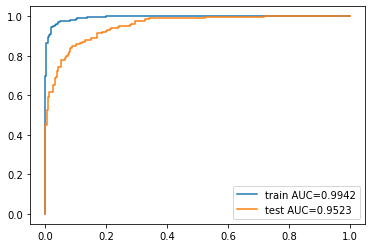

In [66]:
proba = lr_clf.predict_proba(train_features)[:, 1]
auc = roc_auc_score(y_train, proba)
plt.plot(*roc_curve(y_train, proba)[:2], label='%s AUC=%.4f' % ('train', auc))
proba = lr_clf.predict_proba(test_features)[:, 1]
auc = roc_auc_score(y_test, proba)
plt.plot(*roc_curve(y_test, proba)[:2], label='%s AUC=%.4f' % ('test', auc))
plt.legend()

So, how does it look? Did we achieve better results? 

Here come some further ideas:

* Try using the larger BERT (e.g. BERT-base or BERT-large) and compare the results (be careful, they require more memory).

* Using BERT output for translation? Why not ;)

### Bert

In [67]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, 
                                        ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [0]:
texts_train_tokenized = [tokenizer.encode(x, max_length=512, 
                              add_special_tokens=True) for x in texts_train]
texts_test_tokenized = [tokenizer.encode(x, max_length=512, 
                              add_special_tokens=True) for x in texts_test]

In [0]:
padded_train = pad_texts(texts_train_tokenized)
padded_test = pad_texts(texts_test_tokenized)

In [70]:
attention_mask_train = attention_mask(padded_train)
attention_mask_test = attention_mask(padded_test)

attention_mask_train.shape, attention_mask_test.shape

((500, 512), (500, 512))

In [0]:
model = model_class.from_pretrained(pretrained_weights)

In [0]:
model.eval()
model.to(device)
_ = 1

In [0]:
torch.cuda.empty_cache()

In [74]:
output = []
batch_size = 16
for idx in tqdm.tnrange(0, 500, batch_size):
    batch = torch.tensor(padded_train[idx:idx+batch_size]).to(device)
    local_attention_mask = torch.tensor(attention_mask_train[idx:idx+batch_size]).to(device)
    
    with torch.no_grad():
        last_hidden_states = model(batch, attention_mask=local_attention_mask)[0][:,0,:].cpu().numpy()
        output.append(last_hidden_states)

In [75]:
output_test = []
batch_size = 16
for idx in tqdm.tnrange(0, 500, batch_size):
    batch = torch.tensor(padded_test[idx:idx+batch_size]).to(device)
    local_attention_mask = torch.tensor(attention_mask_test[idx:idx+batch_size]).to(device)
    
    with torch.no_grad():
        last_hidden_states = model(batch, attention_mask=local_attention_mask)[0][:, 0, :].cpu().numpy()
        output_test.append(last_hidden_states)

In [76]:
train_features = np.vstack(output)
test_features = np.vstack(output_test)
train_features.shape, test_features.shape

((500, 768), (500, 768))

In [0]:
model.config.output_hidden_states = True

In [91]:
parameters = {'C': np.linspace(0.01, 10, 1000)}
grid_search = GridSearchCV(LogisticRegression(), parameters)
grid_search.fit(train_features, y_train)

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)
lr_clf = grid_search.best_estimator_

best parameters:  {'C': 0.060000000000000005}
best scrores:  0.8520000000000001


In [92]:
lr_clf.score(test_features, y_test)

0.874

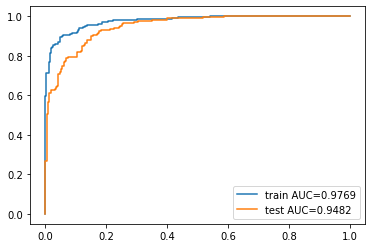

In [93]:
proba = lr_clf.predict_proba(train_features)[:, 1]
auc = roc_auc_score(y_train, proba)
plt.plot(*roc_curve(y_train, proba)[:2], label='%s AUC=%.4f' % ('train', auc))
proba = lr_clf.predict_proba(test_features)[:, 1]
auc = roc_auc_score(y_test, proba)
plt.plot(*roc_curve(y_test, proba)[:2], label='%s AUC=%.4f' % ('test', auc))
plt.legend()